# Simple FEM for one dimensional heat transfer problem

The problem for $T(t,x)$ is stated as
$$
\frac{\partial T}{\partial t} - \alpha \Delta T = 0 \quad \text{for} \quad x \in [0,L] , t \in [0, Z]
$$
with a constant heat conductivity $\alpha$ subject to the boundary condition
$$
T(t, x=0) = 1
$$
and the initial condition
$$
T(t=0, x) = \cos(2\pi x)
$$

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

from global_constants import L, Z, alpha


def pde(x, T):
    dT_t = dde.grad.jacobian(T, x, i=0, j=1)
    dT_xx = dde.grad.hessian(T, x, i=0, j=0)
    return dT_t - alpha * dT_xx

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Spacial and time domains

We represent the inner points in space and time by a set of collocation points.

In [2]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, Z)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


bc = dde.icbc.DirichletBC(geomtime, lambda x: 1, left)
ic = dde.icbc.IC(
    geomtime, lambda x: np.cos(2 * np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=1000, num_boundary=100, num_initial=100
)

## Train the PINN 
We adjust the weights such that the loss is minimized over several epochs.

Compiling model...
'compile' took 0.168058 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.21e-03, 1.00e+00, 4.92e-01]    [1.21e-03, 1.00e+00, 4.92e-01]    []  
1000      [9.30e-04, 2.54e-03, 2.96e-02]    [9.30e-04, 2.54e-03, 2.96e-02]    []  
2000      [1.08e-02, 2.64e-03, 2.27e-02]    [1.08e-02, 2.64e-03, 2.27e-02]    []  
3000      [4.89e-03, 2.42e-03, 1.44e-02]    [4.89e-03, 2.42e-03, 1.44e-02]    []  
4000      [1.86e-03, 2.37e-03, 9.57e-03]    [1.86e-03, 2.37e-03, 9.57e-03]    []  
5000      [2.50e-03, 1.61e-03, 5.61e-03]    [2.50e-03, 1.61e-03, 5.61e-03]    []  
6000      [1.90e-03, 1.23e-03, 3.34e-03]    [1.90e-03, 1.23e-03, 3.34e-03]    []  
7000      [1.40e-03, 9.72e-04, 1.97e-03]    [1.40e-03, 9.72e-04, 1.97e-03]    []  
8000      [2.71e-03, 8.49e-04, 1.66e-03]    [2.71e-03, 8.49e-04, 1.66e-03]    []  
9000      [3.25e-03, 7.93e-04, 1.17e-03]    [3.25e-03, 7.93e-04, 1.17e-03]    []  
10000     [6.57

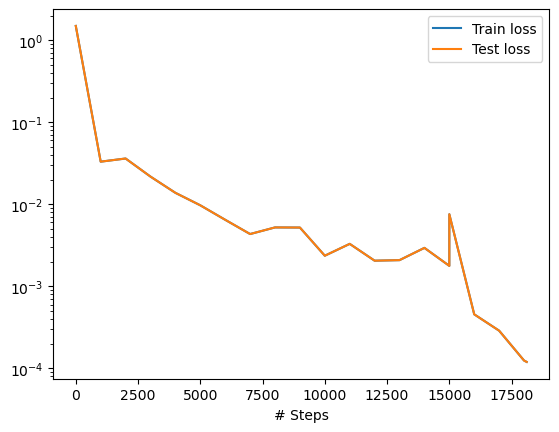

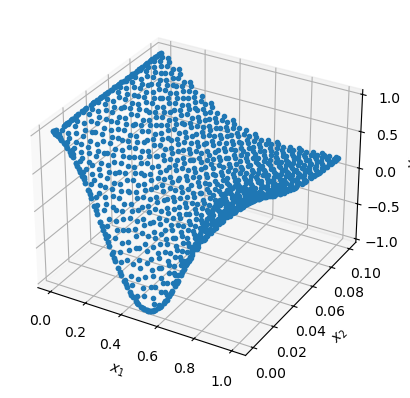

In [3]:
net = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3, loss_weights=[0.1, 1.0, 1.0])
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

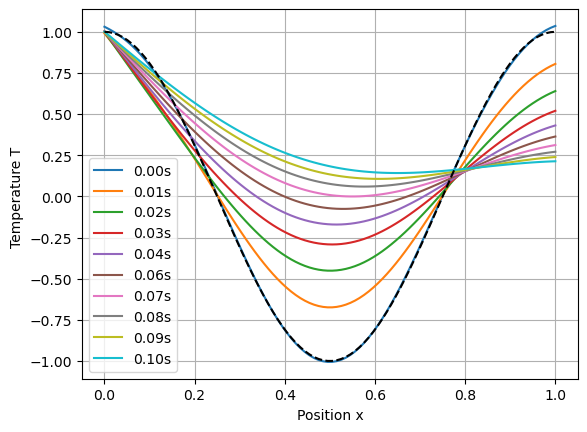

In [4]:
# Plot results
for i in range(10):
    val_x = np.linspace(0, 1, 100)
    val_t = Z / 10 * i * np.ones_like(val_x)
    val = np.vstack((np.ravel(val_x), np.ravel(val_t))).T
    T_v = model.predict(val)
    plt.plot(val_x, T_v)
plt.plot(val_x, np.cos(2 * np.pi * val_x), "--k")
plt.legend([f"{t:.2f}s" for t in np.linspace(0, Z, 10)])
plt.xlabel("Position x")
plt.ylabel("Temperature T ")
plt.grid()
plt.show()